In [1]:
from sys import path as sp
from pathlib import Path
from os import path


# Make scripts directory importable
sp.append(path.join((Path.cwd()).parent,"scripts"))

# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from filepaths import paths
from visualisers import plot_history, plot_activity, plot_axis

# Read Files & Set Column Names

In [3]:
gyrofiles = list(paths.get('GYRO_DIR').glob('*'))
accelfiles = list(paths.get('ACCEL_DIR').glob('*'))

a_column = ['Subject_id', 'Activity_code', 'time', 'ax', 'ay', 'az']
g_column = ['Subject_id', 'Activity_code', 'time', 'gx', 'gy', 'gz']

In [4]:
# pd.read_csv(files[0])
files = []
files = gyrofiles.__add__(accelfiles)

for f in files:
    try:
        pd.read_csv(f)
    except:
        f.unlink()

In [5]:
for i in range(len(gyrofiles)):
    f_g = sorted(gyrofiles)[i]
    f_a = sorted(accelfiles)[i]
    tmp_dfg = pd.read_csv(f_g, names=g_column)
    tmp_dfa = pd.read_csv(f_a, names=a_column)
    # tmp_dfg = tmp_dfg.drop('time', axis=1)
    tmp_dfg = tmp_dfg.drop('time', axis=1).drop(['Subject_id', 'Activity_code'], axis=1)
    if i == 0: 
        full_df = pd.merge(tmp_dfa, tmp_dfg, left_index=True, right_index=True)
    elif i > 0:
        f_df = pd.merge(tmp_dfa, tmp_dfg, left_index=True, right_index=True)
        full_df = pd.concat([full_df, f_df], axis=0, join='outer')


full_df

,Subject_id,Activity_code,time,ax,ay,az,gx,gy,gz
0,1600,A,90426708196641,7.091625,-0.591667,8.195502;,0.314944,-1.022277,-0.3099616;
1,1600,A,90426757696641,4.972757,-0.158317,6.6967316;,0.387382,-0.618541,-0.048971802;
2,1600,A,90426807196641,3.253720,-0.191835,6.107758;,0.070999,-0.209480,-0.1959783;
3,1600,A,90426856696641,2.801216,-0.155922,5.997625;,0.037975,0.254976,-0.1565635;
4,1600,A,90426906196641,3.770868,-1.051354,7.731027;,0.073129,0.719431,-0.0010349044;
...,...,...,...,...,...,...,...,...,...
66551,1650,S,2426182621793652,4.378696,1.139490,15.968727;,-2.856065,2.057101,0.85393304;
66552,1650,S,2426182671786092,-2.475904,4.979790,8.115746;,-2.911458,1.817417,1.2811041;
66553,1650,S,2426182721778532,-7.972991,6.167314,4.160524;,-3.015854,1.550036,2.0576818;
66554,1650,S,2426182771770972,-7.111078,2.863316,4.4406457;,-3.218254,1.595842,3.0185504;


# Filter Specific Classes

In [6]:
# Only keep A G P R
# Walking Brushing Dribbling Clapping
filt_df = full_df[full_df['Activity_code'].isin(['A','G','P','R'])]

# Remove ';' from the z coordinates and convert them back to float64
filt_df['az'] = filt_df['az'].str.slice(start=0, stop=-1)
filt_df['gz'] = filt_df['gz'].str.slice(start=0, stop=-1)
filt_df['az'] = filt_df['az'].astype('float')
filt_df['gz'] = filt_df['gz'].astype('float')

/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_41477/3072446110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['az'] = filt_df['az'].str.slice(start=0, stop=-1)
/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_41477/3072446110.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['gz'] = filt_df['gz'].str.slice(start=0, stop=-1)
/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_41477/3072446110.py:8: SettingWithCopyWarning: 
A value is trying to be set on a 

In [7]:
Fs=20
activities = filt_df['Activity_code'].value_counts().index
activities

Index(['A', 'G', 'P', 'R'], dtype='object')

# Visualise Data

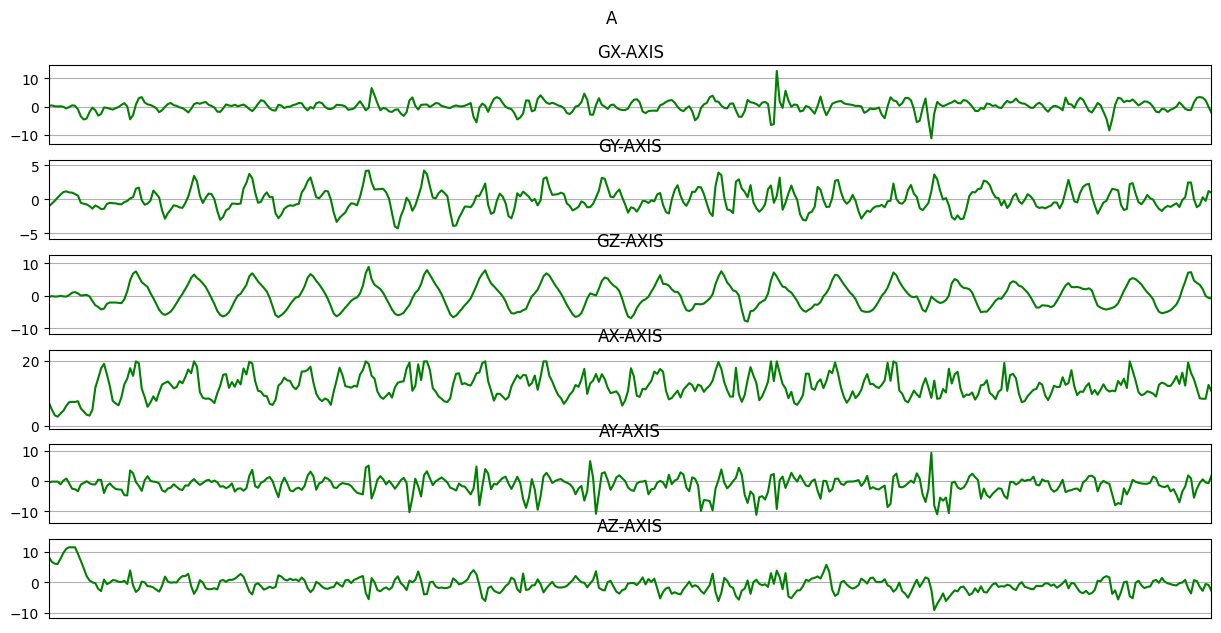

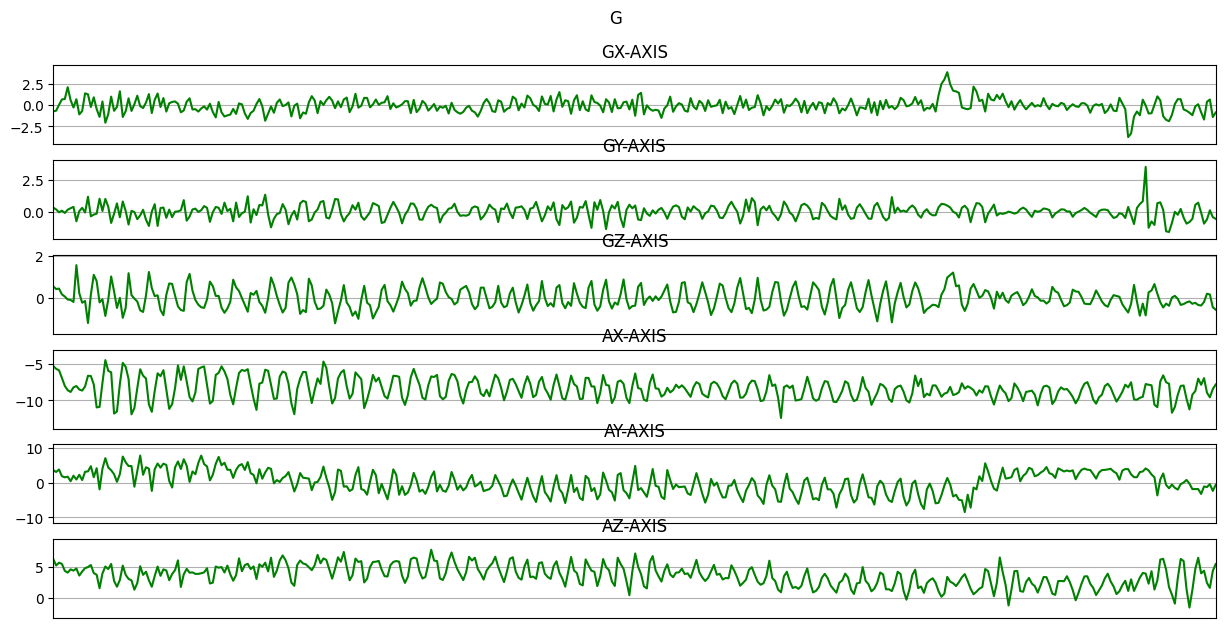

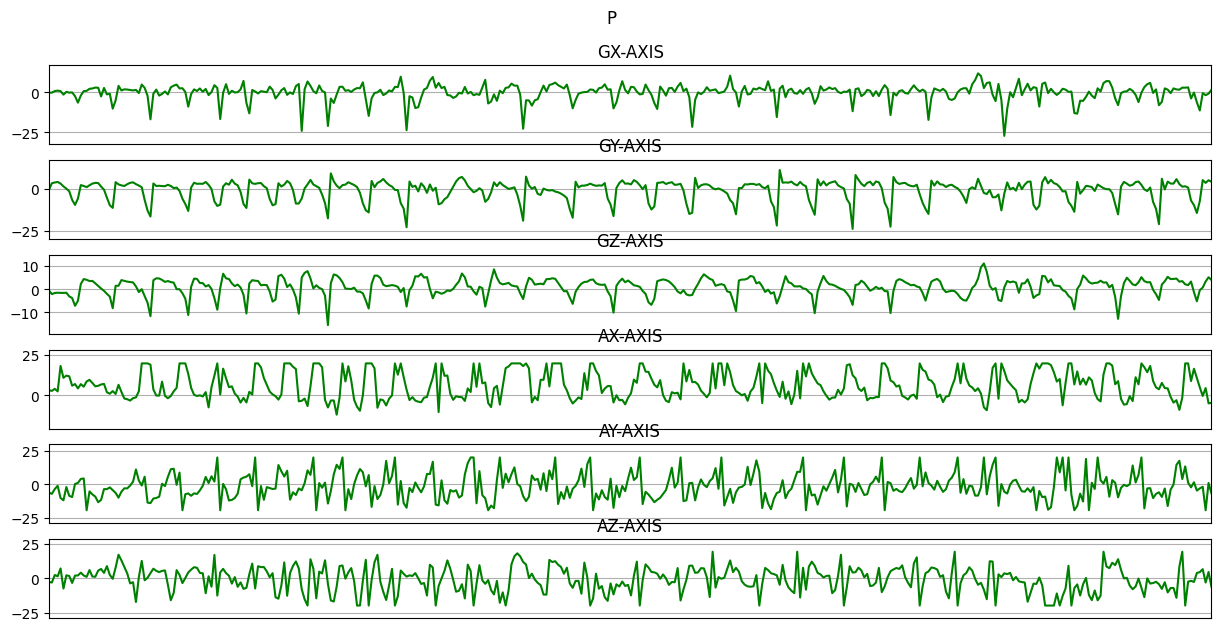

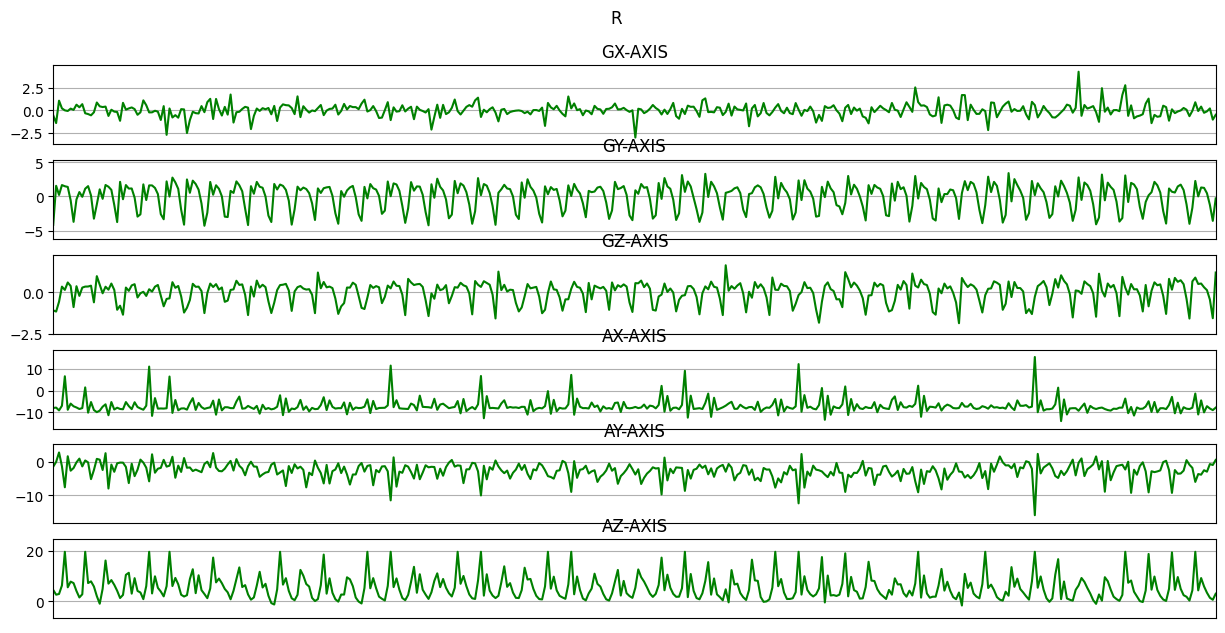

In [8]:
for activity in activities:
    data_for_plot = filt_df[(filt_df['Activity_code'] == activity)][:Fs*20]
    plot_activity(activity, data_for_plot)


In [9]:
filt_df = filt_df.drop('Subject_id', axis=1)
filt_df = filt_df.drop('time', axis=1)

In [10]:
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [11]:
label = LabelEncoder()
filt_df['label'] = label.fit_transform(filt_df['Activity_code'])
filt_df.head()

,Activity_code,ax,ay,az,gx,gy,gz,label
0,A,7.091625,-0.591667,8.195502,0.314944,-1.022277,-0.309962,0
1,A,4.972757,-0.158317,6.696732,0.387382,-0.618541,-0.048972,0
2,A,3.253720,-0.191835,6.107758,0.070999,-0.209480,-0.195978,0
3,A,2.801216,-0.155922,5.997625,0.037975,0.254976,-0.156563,0
4,A,3.770868,-1.051354,7.731027,0.073129,0.719431,-0.001035,0


In [12]:
label.classes_

array(['A', 'G', 'P', 'R'], dtype=object)

In [13]:
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# Checked minmax of gyro to scale from -35 to 35 and accel from -80 to 80
filt_df.apply(minMax)

,Activity_code,ax,ay,az,gx,gy,gz,label
min,A,-39.374123,-43.618100,-52.690434,-32.739010,-32.900143,-20.932430,0
max,R,23.411318,20.127754,32.596220,34.898952,25.071970,15.439269,3


In [14]:
# Scale data to normalize data
def scale_g(x):
    return (x + 35)/70

def scale_a(x):
    return (x + 80)/160

In [15]:
filt_df['gx'] = filt_df['gx'].apply(scale_g)
filt_df['gy'] = filt_df['gy'].apply(scale_g)
filt_df['gz'] = filt_df['gz'].apply(scale_g)
filt_df['ax'] = filt_df['ax'].apply(scale_a)
filt_df['ay'] = filt_df['ay'].apply(scale_a)
filt_df['az'] = filt_df['az'].apply(scale_a)

filt_df

,Activity_code,ax,ay,az,gx,gy,gz,label
0,A,0.544323,0.496302,0.551222,0.504499,0.485396,0.495572,0
1,A,0.531080,0.499011,0.541855,0.505534,0.491164,0.499300,0
2,A,0.520336,0.498801,0.538173,0.501014,0.497007,0.497200,0
3,A,0.517508,0.499025,0.537485,0.500543,0.503643,0.497763,0
4,A,0.523568,0.493429,0.548319,0.501045,0.510278,0.499985,0
...,...,...,...,...,...,...,...,...
62986,R,0.483134,0.440623,0.509992,0.498812,0.497825,0.498838,3
62987,R,0.481623,0.450334,0.536358,0.501612,0.497718,0.500512,3
62988,R,0.472944,0.447087,0.503483,0.504321,0.499605,0.501957,3
62989,R,0.467078,0.445845,0.511249,0.502099,0.502832,0.502353,3


In [16]:
ds_X = filt_df[['gx','gy','gz','ax','ay','az']]
ds_Y = filt_df['label']

scaled_X = pd.DataFrame(data=ds_X, columns=['gx','gy','gz','ax','ay','az'])
scaled_X['Activity_code'] = ds_Y.values

scaled_X

,gx,gy,gz,ax,ay,az,Activity_code
0,0.504499,0.485396,0.495572,0.544323,0.496302,0.551222,0
1,0.505534,0.491164,0.499300,0.531080,0.499011,0.541855,0
2,0.501014,0.497007,0.497200,0.520336,0.498801,0.538173,0
3,0.500543,0.503643,0.497763,0.517508,0.499025,0.537485,0
4,0.501045,0.510278,0.499985,0.523568,0.493429,0.548319,0
...,...,...,...,...,...,...,...
62986,0.498812,0.497825,0.498838,0.483134,0.440623,0.509992,3
62987,0.501612,0.497718,0.500512,0.481623,0.450334,0.536358,3
62988,0.504321,0.499605,0.501957,0.472944,0.447087,0.503483,3
62989,0.502099,0.502832,0.502353,0.467078,0.445845,0.511249,3


In [17]:
import scipy.stats as stats

In [18]:
seconds = 1
frame_size = Fs*seconds # 20Hz * 1 = 20
hop_size = Fs*seconds

In [19]:
def get_frames(filt_df, frame_size, hop_size):
    N_FEATURES = 6

    frames = []
    labels = []
    for i in range(0, len(filt_df) - frame_size, hop_size):
        gx = filt_df['gx'].values[i: i + frame_size]
        gy = filt_df['gy'].values[i: i + frame_size]
        gz = filt_df['gz'].values[i: i + frame_size]
        ax = filt_df['ax'].values[i: i + frame_size]
        ay = filt_df['ay'].values[i: i + frame_size]
        az = filt_df['az'].values[i: i + frame_size]

        # Retrieve most often used label in this segment
        label = stats.mode(filt_df['Activity_code'][i: i + frame_size])[0][0]
        frames.append([gx,gy,gz,ax,ay,az])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels
        

In [20]:
x, y = get_frames(scaled_X, frame_size, hop_size)

/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_41477/3498336246.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(filt_df['Activity_code'][i: i + frame_size])[0][0]


In [21]:
x.shape, y.shape

((38464, 20, 6), (38464,))

In [22]:
BUFFER_SIZE=x.shape[0]
BATCH_SIZE=64

# Turn numpy arrays into tf dataset
ds = tf.data.Dataset.from_tensor_slices(x)
# Cache te dataset
ds = ds.cache()
ds = ds.shuffle(BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE)
# Reduce likelihood of bottlenecking
ds = ds.prefetch(int(BATCH_SIZE/2))

ds.as_numpy_iterator().next().shape

(64, 20, 6)

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [23]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((30771, 20, 6), (7693, 20, 6), (30771,), (7693,))

In [24]:
# For conv2D

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# X_train.shape, X_test.shape


((15385, 20, 6, 1), (3847, 20, 6, 1))

### MODEL BUILD

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam


In [25]:
model = Sequential()
model.add(Conv1D(24, 3, activation='relu', input_shape = X_train[0].shape))
model.add(Dropout(0.2))

model.add(Conv1D(48, 4, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# model.add(Dense(4, activation='softmax'))

# model.add(Input(shape=X_train[0].shape))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

In [26]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 24)            456       
                                                                 
 dropout (Dropout)           (None, 18, 24)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 48)            4656      
                                                                 
 dropout_1 (Dropout)         (None, 15, 48)            0         
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 64)                46144     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [27]:
history = model.fit(X_train, Y_train, epochs=500, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/500


2022-09-29 17:00:03.827206: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


962/962 [==============================] - 3s 3ms/step - loss: 1.0309 - accuracy: 0.5274 - val_loss: 0.6551 - val_accuracy: 0.7216
Epoch 2/500
962/962 [==============================] - 3s 3ms/step - loss: 0.6764 - accuracy: 0.7226 - val_loss: 0.5452 - val_accuracy: 0.7706
Epoch 3/500
962/962 [==============================] - 3s 3ms/step - loss: 0.5842 - accuracy: 0.7664 - val_loss: 0.5012 - val_accuracy: 0.7993
Epoch 4/500
962/962 [==============================] - 2s 3ms/step - loss: 0.5429 - accuracy: 0.7826 - val_loss: 0.4250 - val_accuracy: 0.8300
Epoch 5/500
962/962 [==============================] - 3s 3ms/step - loss: 0.5157 - accuracy: 0.7983 - val_loss: 0.3932 - val_accuracy: 0.8454
Epoch 6/500
962/962 [==============================] - 2s 3ms/step - loss: 0.4844 - accuracy: 0.8130 - val_loss: 0.4120 - val_accuracy: 0.8349
Epoch 7/500
962/962 [==============================] - 2s 3ms/step - loss: 0.4760 - accuracy: 0.8161 - val_loss: 0.3765 - val_accuracy: 0.8583
Epoch 8/500

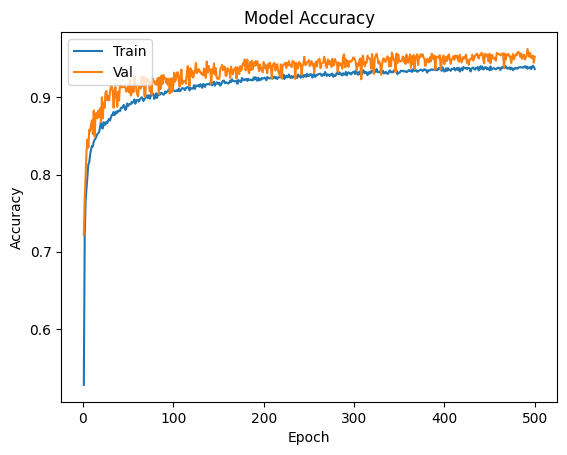

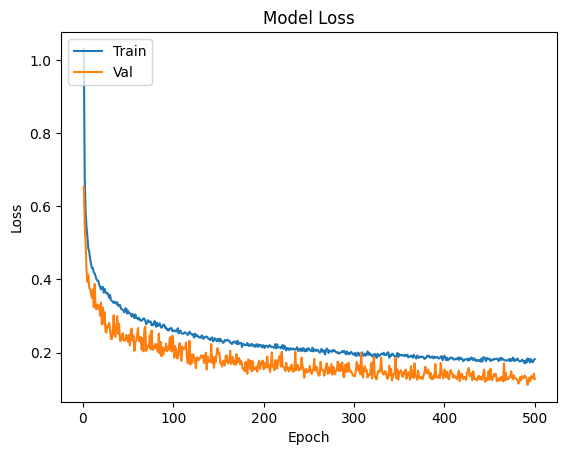

In [28]:
plot_history(history, 500)

# Confusion Matrix

In [29]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [30]:
y_pred = model.predict(X_test)
classes_y = np.argmax(y_pred,axis=1)

241/241 [==============================] - 0s 595us/step


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

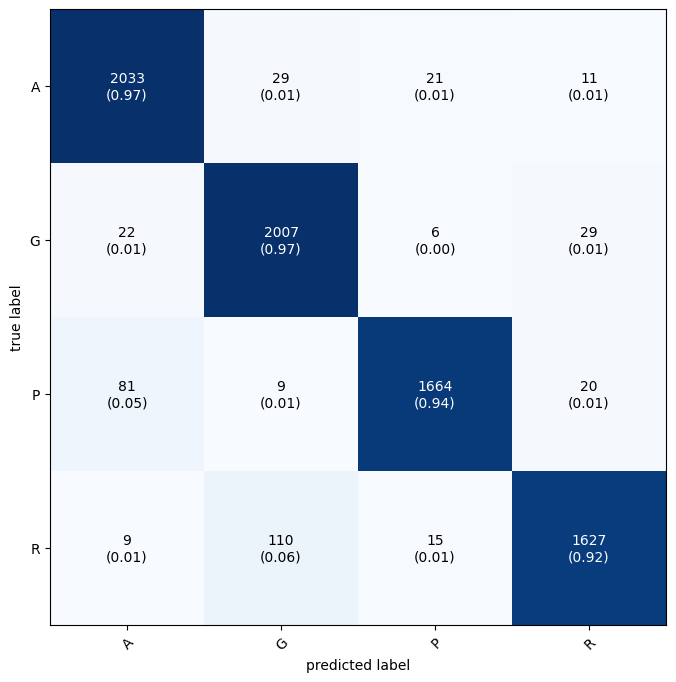

In [31]:
mat = confusion_matrix(Y_test, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(8,8))


# Save Model

In [32]:
model_name = 'mopdel_cnn_000'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model.save(MODEL_DIR)


# Load Model

In [148]:
model_name = 'model_1fs_004'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model = tf.keras.models.load_model(MODEL_DIR)


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 24)            456       
                                                                 
 dropout (Dropout)           (None, 18, 24)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 48)            4656      
                                                                 
 dropout_1 (Dropout)         (None, 15, 48)            0         
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 64)                46144     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [48]:
model.layers[5].get_weights()[1].shape

(64,)

In [33]:
# conv2d_w_0 = model.layers[0].get_weights()[0]
# conv2d_b_0 = model.layers[0].get_weights()[1]

# conv2d_w_1 = model.layers[2].get_weights()[0]
# conv2d_b_1 = model.layers[2].get_weights()[1]

dense_w_0 = model.layers[0].get_weights()[0]
dense_b_0 = model.layers[0].get_weights()[1]

dense_w_1 = model.layers[2].get_weights()[0]
dense_b_1 = model.layers[2].get_weights()[1]

dense_w_2 = model.layers[5].get_weights()[0]
dense_b_2 = model.layers[5].get_weights()[1]

dense_w_3 = model.layers[7].get_weights()[0]
dense_b_3 = model.layers[7].get_weights()[1]

final_w = model.layers[9].get_weights()[0]
final_b = model.layers[9].get_weights()[1]


In [34]:
# layers = np.array([conv2d_w_0,conv2d_b_0,conv2d_w_1,conv2d_b_1,dense_w_0,dense_b_0,dense_w_1,dense_b_1])

layers = np.array([dense_w_0,dense_b_0,dense_w_1,dense_b_1,dense_w_2,dense_b_2,dense_w_3,dense_b_3, final_w, final_b])

for i in layers:
    print(i.shape)

(3, 6, 24)
(24,)
(4, 24, 48)
(48,)
(720, 64)
(64,)
(64, 32)
(32,)
(32, 4)
(4,)


/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_41477/2379089019.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  layers = np.array([dense_w_0,dense_b_0,dense_w_1,dense_b_1,dense_w_2,dense_b_2,dense_w_3,dense_b_3, final_w, final_b])


In [35]:
y_pred = model.predict(X_test[0:20])
classes_y = np.argmax(y_pred,axis=1)
classes_y

1/1 [==============================] - 0s 7ms/step


array([0, 3, 1, 3, 3, 3, 1, 1, 0, 2, 1, 3, 0, 2, 3, 0, 1, 2, 3, 1])

In [36]:
Y_test[0:20]

array([0, 3, 1, 3, 3, 3, 1, 1, 0, 2, 1, 3, 0, 2, 3, 1, 1, 2, 3, 3])

# Save Numpy

In [188]:
# outpath = paths.get('WEIGHT_DIR')
outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'conv1d_y_test')
# SAVE NP
save_np = Y_test

np.save(outpath, save_np)

In [189]:
dataframe = np.array([X_train, X_test, Y_train, Y_test])

outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'conv_df')

np.save(outpath, dataframe)

/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_41477/2591163085.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataframe = np.array([X_train, X_test, Y_train, Y_test])


In [66]:
viz = layers[1]

print(viz)
print(viz.shape)

[ 0.9982494   0.6770703  -0.06876229  0.3487218  -0.01582066  0.
  0.         -0.00355527 -0.20330736 -0.31644577  0.         -0.08707343
  0.          0.         -0.32662997  0.         -0.07762001  0.
 -0.0094172   0.7266123  -0.30941087 -0.52208877 -0.01606345 -0.05250494]
(24,)


In [180]:
def ReLu(x):
    return np.maximum(0,x)

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def kernel_mult(in_dps, kernels):
    # Num of filters (24)
    r = np.empty([in_dps.shape[0]-kernels.shape[0]+1, kernels.shape[2]])
    for j in range(0,kernels.shape[2]):
        # Num of output (shape[0]) > (18)
        out = np.zeros(in_dps.shape[0]-kernels.shape[0]+1)
        for i in range(0, in_dps.shape[0]-kernels.shape[0]+1):
            # Iterate kernel size sum > (3)
            sum = 0
            for k in range(0,kernels.shape[0]):
                # Iterate through prev filters / channels (6) 
                for f in range(0, kernels.shape[1]):
                    sum += kernels[k][f][j]*in_dps[i+k][f]
            r[i][j]=sum
    return r

def kernel_add(in_dps, biases):
    for b in range(0,biases.shape[0]):
        for i in range(0,in_dps.shape[0]):
            in_dps[i][b] += biases[b]
    return in_dps

def self_add(in_dps, biases):
    for i in range(in_dps.shape[0]):
        in_dps[i]+=biases[i]
    return in_dps

In [182]:
# dense_test = X_test[0].reshape(120)
dense_test = X_test[0]
mult = kernel_mult(dense_test, layers[0])
mult = kernel_add(mult, layers[1])
mult = ReLu(mult)
mult = kernel_mult(mult, layers[2])
mult = kernel_add(mult, layers[3])
mult = ReLu(mult)
mult = mult.reshape(720)
mult = np.dot(mult, layers[4])
mult = self_add(mult, layers[5])
mult = ReLu(mult)
mult = np.dot(mult, layers[6])
mult = self_add(mult, layers[7])
mult = ReLu(mult)
mult = np.dot(mult, layers[8])
mult = self_add(mult, layers[9])
mult = ReLu(mult)

mult = softmax(mult)
print(mult.shape)
print(mult)

(4,)
[0.94383589 0.00336869 0.04773736 0.00505805]


In [171]:
intermediate_layers = model.layers[:9]
intermediate_model = Sequential(intermediate_layers)
intermediate_model.build(input_shape=(None,20,6,1))
intermediate_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 24)            456       
                                                                 
 dropout (Dropout)           (None, 18, 24)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 48)            4656      
                                                                 
 dropout_1 (Dropout)         (None, 15, 48)            0         
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 64)                46144     
                                                                 
 dropout_2 (Dropout)         (None, 64)              

In [172]:
yhat = intermediate_model.predict(X_test[0:1])

1/1 [==============================] - 0s 36ms/step


In [173]:
viz = yhat[0]
print(viz.shape)
print(viz)

(32,)
[1.6716375 1.2058766 2.2839592 0.        3.6319957 3.2127683 0.
 0.        0.        5.082264  1.6087092 0.        3.641725  6.5056396
 0.        0.9309373 0.        1.403465  3.2134275 5.833306  0.
 1.0672117 0.        2.969758  1.3515251 0.        2.8756993 0.
 0.        0.        0.        0.       ]


# Print Layers in Cpp

In [285]:
def printCpp(layer):
    wrap = layer.ndim
    if (wrap > 1):
        for i in range(len(layer)):
            print("{", end="")
            printCpp(layer[i])
            if i==len(layer)-1:
                print("}", end="")
            else:
                print("},", end=" \n")
    else:
        for i in range(len(layer)):
            if (i==(len(layer)-1)):
                print(layer[i],end="")
            else:
                print(layer[i],end=", ")


In [305]:
toPrint = layers[6]

print("{", end="")
printCpp(toPrint)
print("};", end="\n")

{{0.031277675, -0.03189297, 0.17986228, 0.013202537, 0.21986361, 0.19519205, 0.09093981, -0.34338412, -0.5711216, -0.005982564, 0.00038830825, -1.7498525, -0.40313873, -0.11490538, -0.29350862, 0.0018962733, -0.57123315, 0.054384537, 0.23816267, 0.15434645, -0.10554123, 0.040869515, -1.4990904, 0.013844568, 0.04758215, 0.024064546, 0.17256722, -0.42586267, -0.0367974, -0.04838466, -0.017627342, -0.11012344}, 
{-0.06276945, -0.05779175, -4.3753705, 0.013440622, -0.8798101, -1.5650616, -0.086692736, 0.39799628, 0.281823, -0.09785876, -0.123570815, 0.30925846, 0.055983517, -0.011479886, 0.4170103, -0.020054102, 0.31747118, 0.047055155, -2.0215304, 0.038662296, 0.11812291, -0.02136129, 0.27401417, -5.300651, -0.0015521412, 0.026850304, -4.631923, 0.35681137, 0.057326823, 0.036950845, 0.051172312, -0.04953959}, 
{0.43637446, 0.22123082, 0.058062583, -0.9065155, 0.05770488, 0.124245875, 0.07304519, 0.029650511, -0.16699673, 0.021055296, 0.43159083, -0.11667237, -0.50637954, -0.2130679, 0.010